In [2]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import json
import bert
import tqdm
from bert.tokenization.bert_tokenization import FullTokenizer

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

from transformers import BertTokenizer

# https://www.youtube.com/watch?v=gE-95nFF4Cc 

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
# !gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output intent/train.csv
# !gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output intent/valid.csv
# !gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output intent/test.csv

In [4]:
train = pd.read_csv("intent/train.csv")
validation = pd.read_csv("intent/valid.csv")
test = pd.read_csv("intent/test.csv")


train=train.append(validation).reset_index()

In [5]:
train.shape

(13784, 3)

In [5]:
train.head()

,index,text,intent
0,0,listen to westbam alumb allergic on google music,PlayMusic
1,1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,2,i give this current textbook a rating value of...,RateBook
3,3,play the song little robin redbreast,PlayMusic
4,4,please add iris dement to my playlist this is ...,AddToPlaylist


[Text(0, 0, 'PlayMusic'),
 Text(1, 0, 'AddToPlaylist'),
 Text(2, 0, 'RateBook'),
 Text(3, 0, 'SearchScreeningEvent'),
 Text(4, 0, 'BookRestaurant'),
 Text(5, 0, 'GetWeather'),
 Text(6, 0, 'SearchCreativeWork')]

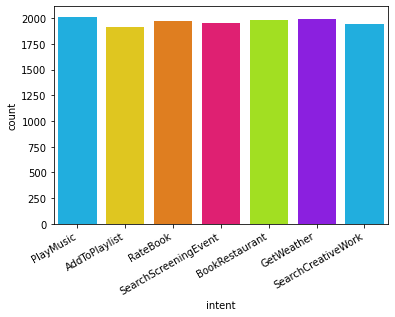

In [6]:
chart = sns.countplot(train.intent, palette=HAPPY_COLORS_PALETTE)
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment="right")

In [19]:
# This class handles the tokenizing and padding of our dataset. Each dataset will have a slightly different way to do each step. On regular
# TF packages, https://www.coursera.org/learn/natural-language-processing-tensorflow/lecture/2Cyzs/padding, you can see that they have methods that # tokenize and pad together that work seamlessly. Because we are using a pretrained model, bert-tf2, these are not available to us (not sure why tbh, probably because we want to use the pretrained tokenizer which requires us to not use TF methods)
class IntentDetection:
    DATA = "text"
    LABELS = "intent"

    def __init__(self, train, test,  classes, tokenizer:FullTokenizer, max_sequence_length=192):
        self.tokenizer = tokenizer
        self.max_sequence_length = 0
        self.classes = classes

        # train, test = map(lambda df: df.reindex(df[IntentDetection.DATA].str.len().sort_values().index), [train, test])

        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])
        self.max_sequence_length = min(self.max_sequence_length, max_sequence_length)
        self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])


    def _prepare(self, data_frame):
        x, y = [], []
        for _, row in tqdm.tqdm(data_frame.iterrows()):
            text, label = row[IntentDetection.DATA], row[IntentDetection.LABELS]
            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"]+tokens+["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

            self.max_sequence_length = max(self.max_sequence_length, len(token_ids))
            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []

        for input_ids in ids:
            # cut_off = min(len(input_ids), self.max_sequence_length-2)
            cut_off = min(len(input_ids), self.max_sequence_length)
            input_ids[:cut_off] 
            input_ids = input_ids + [0]*(self.max_sequence_length-len(input_ids))
            x.append(np.array(input_ids))
        
        return np.array(x)

In [20]:
# https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
tokenizer = FullTokenizer(vocab_file="bert_en_uncased_L-12_H-768_A-12_2/assets/vocab.txt")

In [21]:
bert_model = tf.saved_model.load("./bert_en_uncased_L-12_H-768_A-12_2")

In [22]:
classes = train.intent.unique().tolist()
data = IntentDetection(train, test, classes, tokenizer,  max_sequence_length=192)

13784it [00:02, 5982.28it/s]
700it [00:00, 5926.42it/s]


In [30]:
type(data.train_y)
for x in data.train_y:
    print(type(x))

<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'nu

In [24]:
def create_model(max_sequence_length, bert_model):
    tf.keras.backend.clear_session()

    input_layer = keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name="input_layer")
    input_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name="segment_ids")
    bert_layer = hub.KerasLayer(bert_model, trainable=True)
    pooled, seq = bert_layer([input_layer, input_mask, segment_ids])

    # input_l = tf.keras.layers.Input(shape=pooled.shape)
    # x = bert_layer()(input_l)

    # x = keras.layers.Lambda(lambda seq: seq[:, 0, :])(seq)
    # print(x.shape)
    x = keras.layers.Layer(pooled.shape)(pooled)
    x = keras.layers.Dropout(0.5)(x)

    x = keras.layers.Dense(768, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(len(classes), activation="softmax")(x)
    model = keras.Model([input_layer, input_mask, segment_ids], x, name="bert_model")
    return model

In [25]:
model = create_model(data.max_sequence_length, bert_model)
model.summary()

Model: "bert_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 38)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 38)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_layer[0][0]                
                                                                 input_mask[0][0]        

In [26]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [27]:
check_points = "checkpoint/checkpoint.hb"
check_point_dir = os.path.dirname(check_points)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=check_point_dir, verbose=1, monitor="val_sparse_categorical_accuracy", save_best_only=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="log_dir")

In [28]:
# the data.train_x is tokenized BEFORE the model begins running. First we create the tokenizer, then we embed the tokenizer with
# a giant corpus of words not related to our data. Then we use that tokenizer on our data to put all the sentences in a token-form.
# The tokenized data is then used to train the model.
mask = np.zeros(data.train_x.shape)
seg = np.zeros(data.train_x.shape)
history = model.fit(x=[data.train_x, mask, seg], y=data.train_y, verbose=1, validation_split=0.1, batch_size=16, shuffle=True,
use_multiprocessing=True, workers=5, epochs=5, callbacks=[cp_callback, tensorboard_callback])

Train on 12405 samples, validate on 1379 samples

Got `type(handle)`: <class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'>
Epoch 1/5
   16/12405 [..............................] - ETA: 22:22WARNING:tensorflow:Can save best model only with val_sparse_categorical_accuracy available, skipping.


KeyboardInterrupt: 

In [21]:
model_folder = "model_path"
os.makedirs(model_folder, exist_ok=True)

In [22]:
saved_model = "saved_model"
model_path = os.path.join(model_folder, saved_model)
tf.saved_model.save(model, model_path)

INFO:tensorflow:Assets written to: model_path\saved_model\assets


In [25]:
model = tf.keras.models.load_model(model_path)

In [29]:
mask = np.zeros(data.train_x.shape)
seg = np.zeros(data.train_x.shape)
tmask = np.zeros(data.test_x.shape)
tseg = np.zeros(data.test_x.shape)

train_loss, train_acc = model.evaluate([data.train_x, mask, seg], data.train_y, batch_size=32)
test_loss, test_acc = model.evaluate([data.test_x, tmask, tseg], data.test_y, batch_size=32)

print("train acc", train_acc)
print("train acc", test_acc)

700/700 [==============================] - 1s 1ms/sample - loss: 0.1037 - sparse_categorical_accuracy: 0.9757
train acc 0.99840397
train acc 0.97571427


In [33]:
print(data.train_x[4])
tok = tokenizer.tokenize("[CLS] listen to westbam alumb allergic on google music")
tokenizer.convert_tokens_to_ids(tok)

[  101  3531  5587 11173 17183  4765  2000  2026  2377  9863  2023  2003
 19166   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


[1031,
 18856,
 2015,
 1033,
 4952,
 2000,
 2225,
 3676,
 2213,
 2632,
 25438,
 27395,
 2006,
 8224,
 2189]

In [42]:
tok = tokenizer.tokenize("[CLS] google play Bank account")
x = tokenizer.convert_tokens_to_ids(tok)
print(x)
np_x = np.array(x)
np_x.shape

[1031, 18856, 2015, 1033, 8224, 2377, 2924, 4070]


(8,)

In [26]:
sentences = [
  "how hot is it outside",
  "Rate this book as awful"
]
print(classes)
%precision 4

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_sequence_length-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))
x1, x2 = np.zeros(pred_token_ids.shape), np.zeros(pred_token_ids.shape)

predictions = model.predict([pred_token_ids, x1, x2])
print(predictions)
# for text, label in zip(sentences, predictions):
#   print("text:", text, "\nintent:", classes[label])
#   print()

# output = model.predict([data.test_x, tmask, tseg])
# print(output)

['PlayMusic', 'AddToPlaylist', 'RateBook', 'SearchScreeningEvent', 'BookRestaurant', 'GetWeather', 'SearchCreativeWork']
[[4.1529e-06 8.5281e-06 1.0275e-05 1.6650e-05 2.8404e-05 9.9991e-01
  1.9150e-05]
 [9.6475e-05 4.8393e-05 9.9833e-01 1.0778e-04 4.1708e-05 2.1716e-04
  1.1621e-03]]
